In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd

In [14]:
from copy import deepcopy

import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


class FeatureSubsetModel(BaseEstimator, RegressorMixin):

    def __init__(self, group_cols=None, sub_models=None):
        """
        Build regression model for subsets of feature rows matching particular combination of feature columns.
        
        """

        self.group_cols = deepcopy(group_cols) if group_cols else None
        self.sub_models = deepcopy(sub_models) if sub_models else None

    def fit(self, X, y):
        """
        Partition the training data, X, into groups for each unique combination of values in 
        ``self.group_cols`` columns. For each group, train the appropriate model specified in 
        ``self.sub_models``.
        """
        groups = X.groupby(by=list(self.group_cols))

        for gp_key, x_group in groups:
            # Find the sub-model for this group key
            gp_model = self.sub_models[gp_key]
            
            # Drop the feature values for the group columns, since these are same for all rows
            # and so don't contribute anything into the prediction.
            x_in = x_group.drop([n for n in self.group_cols], axis=1)
            y_in = y.loc[x_in.index]

            # Fit the submodel with subset of rows
            gp_model = gp_model.fit(X=x_in.values, y=y_in.values)
            self.sub_models[gp_key] = gp_model

        return self

    def predict(self, X):
        """
        Same as ``self.fit()``, but call the ``predict()`` method for each submodel and return the results.
        """
        groups = X.groupby(by=list(self.group_cols))
        results = []

        for gp_key, x_group in groups:
            gp_model = self.sub_models[gp_key]
            x_in = x_group.drop([n for n in self.group_cols], axis=1)

            result = gp_model.predict(X=x_in.values)

            result = pd.Series(index=x_in.index, data=result)
            results.append(result)

        return pd.concat(results, axis=0)

In [15]:
def make_dataset(random_state, n_informative, **kwargs):
    x, y = make_regression(
        
        n_samples=1000, 
        n_features=5,
        noise=0 if random_state == 1 else 10,
        bias=10 if random_state == 1 else 1000,
        n_informative=min(n_informative, 5), 
        random_state=random_state
    )
    x = pd.DataFrame(x)
    x.columns = ['feature_{}'.format(n) for n in x.columns]
    x = x.assign(**kwargs)
    
    return x, pd.Series(y)

In [17]:
subset_cols = ('account_banner', 'product_desc')
sub_models = {
    ('A', 'X'): LinearRegression(),
    ('B', 'Y'): SGDRegressor(),
}

model = FeatureSubsetModel(group_cols=subset_cols, sub_models=sub_models)

# Generate two sets of artificial regression data with different characteristics

x1, y1 = make_dataset(1, 5, account_banner='A', product_desc='X')
x2, y2 = make_dataset(2, 3, account_banner='B', product_desc='Y')

# combine into one dataset
total_x = pd.concat([x1, x2], axis=0, ignore_index=True).reset_index(drop=True)
total_y = pd.concat([y1, y2], axis=0, ignore_index=True).reset_index(drop=True)

# Split into train and test
train_index, test_index = train_test_split(total_x.index, random_state=5)
train_x, train_y = total_x.loc[train_index, :], total_y.loc[train_index]
test_x, test_y = total_x.loc[test_index, :], total_y.loc[test_index]

model = model.fit(train_x, train_y)
results = model.predict(test_x)

51        34.241301
417      -64.680038
269       80.844118
191       73.619755
436       12.566498
           ...     
1852    1055.511575
1356    1041.595320
1493     868.514740
1306    1022.328589
1607    1086.257925
Length: 500, dtype: float64
51        34.241301
1327    1083.752391
1488    1039.746891
1432    1193.665579
417      -64.680038
           ...     
1493     866.937570
886      118.225953
1306    1017.702255
279       96.873484
1607    1072.301312
Length: 500, dtype: float64


In [18]:
comp = pd.concat({'actual':test_y, 'predicted': results}, axis=1)
cat_features = test_x.loc[:, ['account_banner', 'product_desc']].apply(lambda x: '-'.join(x.values), axis=1)
comp = pd.concat([comp, cat_features], axis=1)
comp.columns = ['actual', 'predicted', 'subset']

In [19]:
comp.head()

,actual,predicted,subset
4,15.117545,15.117545,A-X
7,-76.836525,-76.836525,A-X
12,115.491036,115.491036,A-X
15,223.554056,223.554056,A-X
26,-84.161989,-84.161989,A-X


In [20]:
comp = comp.melt(id_vars=['subset',], var_name='type')

In [21]:
comp.head()

,subset,type,value
0,A-X,actual,15.117545
1,A-X,actual,-76.836525
2,A-X,actual,115.491036
3,A-X,actual,223.554056
4,A-X,actual,-84.161989


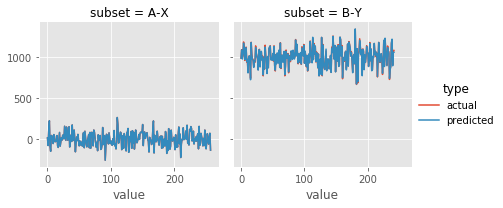

In [9]:
import seaborn as sns

# plot the predicted values of the target and the ground truth values for each subset.

fg = sns.FacetGrid(data=comp, col='subset', hue='type')
fg = fg.map(plt.plot, 'value')
fg = fg.add_legend()